In [49]:
"""
author: Zhuofan Liu

email: liuzhuofan97@gmail.com
"""

import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers

import jax
import itertools
from functools import partial
from tqdm import trange

import skfmm
from scipy.stats.qmc import Halton

onp.random.seed(1234)
random_key = random.PRNGKey(0)
jax.config.update("jax_default_device", jax.devices()[1])

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [50]:
## Choose velocity family to train
velocity_family= onp.load('Style_A.npy')
# velocity_family= onp.load('Curvefault_A.npy')
# velocity_family= onp.load('Curvefault_B.npy')
# velocity_family= onp.load('FlatFault_A.npy')

onp.random.shuffle(velocity_family)
num_velocity = 100
num_sources= 20

velmodel0 = velocity_family[:num_velocity,0,:,:]
velmodel = np.array(velmodel0)/1000


# Velocity at origin
z_min = 0.; z_max = 0.69; z_delta = 0.01;
x_min = 0.; x_max = 0.69; x_delta = 0.01;

grid_size = int(z_max/z_delta)+1

# Point-source location
sz = 0.2; sx = 0.1;

z = onp.arange(z_min,z_max+z_delta,z_delta)
x = onp.arange(x_min,x_max+x_delta,x_delta)

Z,X = jnp.meshgrid(z,x,indexing='ij')

coordinates = jnp.dstack((Z, X)).reshape(-1, 2)

location source [[ 0 60]
 [ 0 14]
 [ 0 37]
 [ 0 67]
 [ 0 21]
 [ 0 44]
 [ 0 52]
 [ 0  6]
 [ 0 29]
 [ 0 55]
 [ 0  9]
 [ 0 32]
 [ 0 62]
 [ 0 16]
 [ 0 39]
 [ 0 47]
 [ 0  1]
 [ 0 24]
 [ 0 57]
 [ 0 11]]


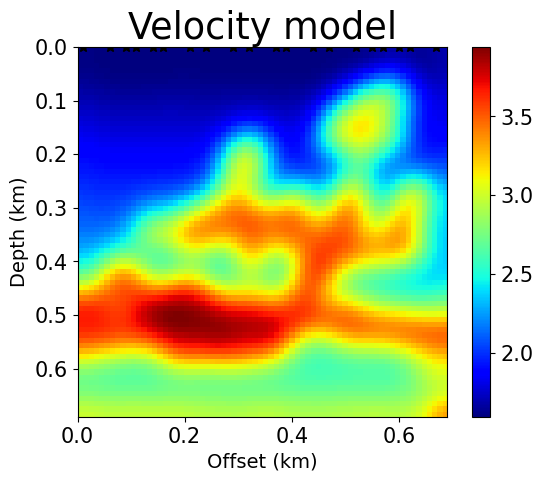

In [51]:
def grad_plot(title, data, source):
    vmin=jnp.min(data)
    vmax=jnp.max(data)
    
    row,collum=data.shape
    row_n=(row-1)*z_delta
    collum_n=(collum-1)*z_delta
    
    plt.figure()
    plt.imshow(data, cmap="jet" ,extent=[0,row_n,collum_n,0], vmin=vmin, vmax=vmax)
    # plt.imshow(data, cmap="jet", vmin=vmin, vmax=vmax)
    if source is not None:
        for (z, x) in source:
            # Convert source coordinates if they are integers greater than 1
            z = z * z_delta
            x = x * z_delta
            plt.plot(x, z, 'k*', markersize=8)

    plt.title(title)
    plt.colorbar()
    plt.xlabel('Offset (km)', fontsize=14)
    # plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=14)

def grad_plot2(title, data, source):
    vmin=jnp.min(data)
    vmax=jnp.max(data)
    
    row,collum=data.shape
    row_n=(row-1)*z_delta
    collum_n=(collum-1)*z_delta
    
    plt.figure()
    plt.imshow(data, cmap="jet" ,extent=[0,row_n,collum_n,0], vmin=1.8, vmax=4.3)
    # plt.imshow(data, cmap="jet", vmin=vmin, vmax=vmax)
    if source is not None:
        for (z, x) in source:
            # Convert source coordinates if they are integers greater than 1
            z = z * z_delta
            x = x * z_delta
            plt.plot(x, z, 'k*', markersize=8)

    plt.title(title)
    plt.colorbar()
    plt.xlabel('Offset (km)', fontsize=14)
    # plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=14)

# grad_plot('Velocity model', velmodel, source=jnp.array([(sx0/z_delta ,sz0/z_delta)]))

# Function to generate random source locations

def generate_random_points(num_sources, dimensions=2):
    
    # Create a Halton sequence sampler
    sampler = Halton(d=dimensions, seed=1234)
    
    # Generate points
    points = sampler.random(n=num_sources)
    
    # Scale the points to the grid size
    points *= (grid_size - 1)
    
    # Convert to integer indices
    points = np.round(points).astype(int)
    
    points = jnp.array(list(map(tuple, points)))
    
    return points

# Saves the randomly generated source locations
random_source_loc = generate_random_points(num_sources)

random_source_loc = random_source_loc.at[:,0].set(0)

print('location source',random_source_loc )

grad_plot('Velocity model', velmodel[0,:,:] , random_source_loc)

In [52]:
m = grid_size*grid_size
P = m

def gen_data(grid_size=grid_size,
             num_sources=num_sources,
             num_velocity = num_velocity,
             coordinates=coordinates,
             source=None,
             velocity_model= velmodel ,
             spacing=z_delta ,
             P=P):

    V_all = []     
    T0_all = []    
    y_coord = []  
    Tau_all = []  
    T_all = [] 
    px_all = []
    pz_all = []
    s_point = []
    source_loc = source

    for k in range(num_velocity):
        for i in range(num_sources):
            
            sz = source_loc[i][0]
            sx = source_loc[i][1]
            
            V0_s=velocity_model[k, sz, sx]
   
            source_point = onp.ones((grid_size,grid_size)) * jnp.inf
            source_point[source_loc[i][0], source_loc[i][1]] = 0
            
            # # Solve the travel time using the SKFMM
            T_data = skfmm.travel_time(source_point, velocity_model[k, :, :], dx=spacing, order=2)
            
            T0 = jnp.sqrt((Z-sz*z_delta)**2 + (X-sx*z_delta)**2)/V0_s
            
            Tau = T_data - T0

            px0 = onp.divide(X-(sx* z_delta)._value, T0*V0_s**2, out=onp.zeros_like(T0), where=T0!=0)
            pz0 = onp.divide(Z-(sz* z_delta)._value, T0*V0_s**2, out=onp.zeros_like(T0), where=T0!=0)
            
            px0[sz,sx] = 0.3
  
            # Appends dataset to defined list above
            V_all.append(velocity_model[k, :, :])
            T0_all.append(T0)
            y_coord.append(coordinates)
            Tau_all.append(Tau)
            T_all.append(T_data)
            px_all.append(px0)
            pz_all.append(pz0)
            s_point.append(jnp.array([sz,sx]))

    # Stacks data for all sources
    V_input = jnp.vstack(V_all).flatten().reshape(num_sources*num_velocity ,grid_size, grid_size,1)
    T0_input = jnp.vstack(T0_all).flatten().reshape(num_sources*num_velocity, grid_size, grid_size,1)
    y_coord_ = jnp.vstack(y_coord).flatten().reshape(num_sources*num_velocity,grid_size, grid_size,2)
    Tau_input = jnp.vstack(Tau_all).flatten().reshape(num_sources*num_velocity, grid_size, grid_size,1)
    T_output = jnp.vstack(T_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size,1)
    px_output = jnp.vstack(px_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size)
    pz_output = jnp.vstack(pz_all).flatten().reshape(num_sources*num_velocity,grid_size, grid_size)
    s_point = jnp.array(s_point).reshape(num_sources*num_velocity, 2)

    return V_input, T0_input, y_coord_, Tau_input, T_output, source_loc, px_output, pz_output, s_point

V_, T0_, y_, Tau_, T_, sloc, px_, pz_, source_point= gen_data(num_sources=1, num_velocity=1, source = [random_source_loc[0]])

V_16, T0_16, y_16, Tau_16, T_16, sloc_16, px_16, pz_16, source_point16 = gen_data(num_sources=num_sources, source = random_source_loc)


In [53]:
import jax.numpy as jnp
from jax import random, grad, jit, vjp
from jax.example_libraries.optimizers import optimizer, make_schedule
from jax.example_libraries.stax import Gelu, serial
from jax.nn.initializers import glorot_uniform, normal, glorot_normal
from jax.flatten_util import ravel_pytree
import timeit

@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
  """Construct optimizer triple for complex-valued Adam.

  Args:
    step_size: positive scalar, or a callable representing a step size schedule
      that maps the iteration index to positive scalar.
    b1: optional, a positive scalar value for beta_1, the exponential decay rate
      for the first moment estimates (default 0.9).
    b2: optional, a positive scalar value for beta_2, the exponential decay rate
      for the second moment estimates (default 0.999).
    eps: optional, a positive scalar value for epsilon, a small constant for
      numerical stability (default 1e-8).

  Returns:
    An (init_fun, update_fun, get_params) triple.
  """
  step_size = make_schedule(step_size)
  def init(x0):
    m0 = jnp.zeros_like(x0)
    v0 = jnp.zeros_like(x0)
    return x0, m0, v0
  def update(i, g, state):
    x, m, v = state
    g = jnp.conj(g) # <- conjugate
    m = (1 - b1) * g + b1 * m  # First  moment estimate.
    v = (1 - b2) * jnp.real(jnp.conj(g)* g) + b2 * v  # Second moment estimate.
    mhat = m / (1 - b1 ** (i + 1))  # Bias correction.
    vhat = v / (1 - b2 ** (i + 1))
    x = x - step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
    return x, m, v
  def get_params(state):
    x, m, v = state
    return x
  return init, update, get_params


class DataGenerator():
    def __init__(self, T0, V, pz, px, targets, source_point16,
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        # self.inputs = inputs
        self.T0 = T0
        self.V = V
        self.pz = pz
        self.px = px
        self.targets = targets
        self.source_point16 = source_point16
        self.N = targets.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, T0, V, pz, px, targets, source_point16):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        T0 = T0[idx,...]
        V = V[idx,...]
        pz = pz[idx,...]
        px = px[idx,...]
        targets = targets[idx,...]
        source_point16 = source_point16[idx,...]
        return T0, V, pz, px, targets, source_point16

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        T0, V, pz, px, targets, source_point16 = self.__data_generation(self.key, self.T0, self.V, self.pz, self.px, self.targets, self.source_point16)
        return T0, V, pz, px, targets, source_point16
     

def Dense(out_dim, W_init=glorot_normal(), b_init=normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
        return output_shape, (W, b)
    def apply_fun(params, inputs, **kwargs):
        W, b = params
        return jnp.dot(inputs, W) + b
    return init_fun, apply_fun


def Permute(order):
    """Layer constructor function for a permutation layer."""
    def permutation_indices(order):
        if order=="ijkl->iljk":
            return (0,3,1,2)
        elif order=="ijkl->iklj":
            return (0,2,3,1)
        else:
              raise NotImplementedError
    def init_fun(rng, input_shape):
        idx = permutation_indices(order)
        output_shape = tuple([input_shape[i] for i in idx])
        return output_shape, ()
    def apply_fun(params, inputs, **kwargs):
        outputs = jnp.einsum(order, inputs)
        return outputs
    return init_fun, apply_fun

def SpectralConv2d(modes, W_init=glorot_uniform(dtype=jnp.complex64), b_init=None):
    """Layer constructor function for a SpectralConv2d layer."""
    def compl_mul2d(input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return jnp.einsum("bixy,ioxy->boxy", input, weights)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        output_shape = input_shape
        width = input_shape[1]
        W1 = W_init(k1, (width, width, modes, modes))
        W2 = W_init(k2, (width, width, modes, modes))
        return output_shape, (W1, W2)

    def apply_fun(params, inputs, **kwargs):
        W1, W2 = params
        batchsize = inputs.shape[0]
        _, out_channels, modes1, modes2 = W1.shape
        x_ft = jnp.fft.rfft2(inputs)
        out_ft = jnp.zeros((batchsize, out_channels,  inputs.shape[-2], inputs.shape[-1]//2 + 1), dtype=jnp.complex64)
        out_ft = out_ft.at[:, :, :modes1, :modes2].set(compl_mul2d(x_ft[:, :, :modes1, :modes2], W1))
        out_ft = out_ft.at[:, :, -modes1:, :modes2].set(compl_mul2d(x_ft[:, :, -modes1:, :modes2], W2))
        out_ft = jnp.fft.irfft2(out_ft, s=(inputs.shape[-2], inputs.shape[-1]))
        return out_ft
    return init_fun, apply_fun


def FNOBlock2D(out_channels, modes):
    """Layer constructor function for a 2D FNO block."""
    conv_init, conv_apply = SpectralConv2d(modes)
    dense_init, dense_apply = Dense(out_channels)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        _, conv_params = conv_init(k1, input_shape)
        output_shape, dense_params = dense_init(k2, input_shape)
        return output_shape, (conv_params, dense_params)
    def apply_fun(params, inputs, **kwargs):
        conv_params, dense_params = params
        x1 = conv_apply(conv_params, inputs)
        x2 = dense_apply(dense_params, inputs)
        outputs = x1 + x2
        return outputs
    return init_fun, apply_fun

class LpLoss(object):
    def __init__(self, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p

    def rel(self, x, y):
        num_examples = x.shape[0]
        diff_norms = jnp.linalg.norm(y.reshape(num_examples,-1) - x.reshape(num_examples,-1), self.p, 1)
        y_norms = jnp.linalg.norm(y.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

class FNO:
    def __init__(self, input_shape, layers, layers_branch1, layers_branch2):
        # Apply and init functions
        self.init, self.apply = serial(*layers) 
        self.init_branch1, self.apply_branch1 = serial(*layers_branch1) 
        self.init_branch2, self.apply_branch2 = serial(*layers_branch2) 
        
        _, params_FNO = self.init(random.PRNGKey(10000), input_shape)
        _, params_branch1 = self.init_branch1(random.PRNGKey(10000), input_shape)
        _, params_branch2 = self.init_branch2(random.PRNGKey(10000), input_shape)
        params = (params_FNO, params_branch1, params_branch2)

        # Relative L2 loss
        self.L2Loss = LpLoss()

        # Optimizer
        self.opt_init, self.opt_update, self.get_params = complex_adam(1e-4)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def operator(self, params, T0, V):
        params_FNO, params_branch1, params_branch2 = params
        B1 = self.apply_branch1(params_branch1, T0)
        B2 = self.apply_branch2(params_branch2, V)

        outputs = self.apply(params_FNO,B1*B2)
        return outputs

    @partial(jit, static_argnums=0)
    def loss(self, params, batch):
        T0, V, pz, px, targets = batch
        
        outputs = self.operator(params, T0, V)
        loss = self.L2Loss(outputs, targets)
        return loss   
    @partial(jit, static_argnums=0)
    def loss_PINN(self, params, batch):
        T0, V, pz, px, targets, source = batch
        tau = self.operator(params, T0, V)
        source_z = source[:,0]
        
        # mask = jnp.where(T0<0.01,T0,1)
        # mask = mask.at[:,0,:].set(0)
        tau = tau.at[:,0,:].set(0)
        
        dtau_dz = jnp.gradient(tau.reshape(-1, grid_size, grid_size), z_delta, axis=1)
        dtau_dx = jnp.gradient(tau.reshape(-1, grid_size, grid_size), x_delta, axis=2)
        
        term1 = dtau_dz + pz
        term2 = dtau_dx + px
        
        V = V.reshape(-1, grid_size, grid_size)
        
        pde = term1**2 +term2**2 - 1/ V**2
        
        loss = self.MSE(pde,jnp.zeros(pde.shape)) 
        return loss 

    
    def MSE(self, true,pred):
        return jnp.mean((true.flatten()-pred.flatten())**2)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, f_weights, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_PINN)(params, batch)
        # g_f = grad(self.loss_PINN)(f_weights, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, dataset, f_weights, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, f_weights, batch)
            # Logger
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                # loss = self.loss(params, batch)
                loss = self.loss_PINN(params, batch)
                # loss_initial0 = self.loss_initial(params, batch)
                # error = self.L2error(params, batch)
                self.loss_log.append(loss)
                # self.loss_initial_log.append(loss_initial0)
                pbar.set_postfix({'Loss': loss})

    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])
    def predict(self, params, T0, V):
        params_FNO, params_branch1, params_branch2 = params
        # inputs, targets = batch
        outputs = self.operator(params, T0, V)
        return outputs

The number of model parameters is: 419073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [1:29:44<00:00, 92.85it/s, Loss=0.00040615496]


The training wall-clock time is seconds is equal to 5384.759260 seconds


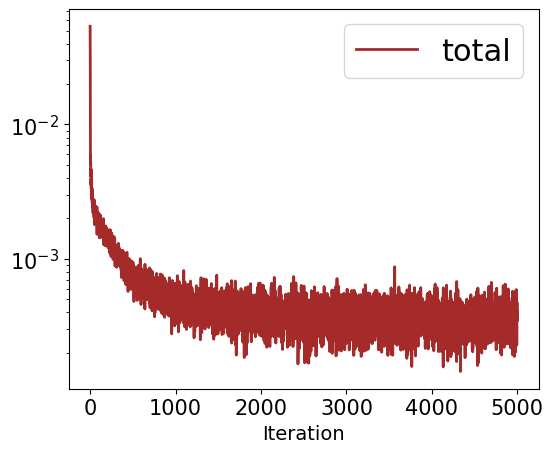

In [54]:
# Specify the problem parameters

batch_size = 32

h = 70
width = 32
modes = 8

y_train = Tau_16

f_weights = jnp.ones((num_sources*num_velocity,1))

train_dataset = DataGenerator(T0_16, V_16, pz_16, px_16,  y_train, source_point16, batch_size)
train_dataset = iter(train_dataset)

# Specify the model architecture
input_shape = (-1, h, h, 1) # do not commit to a fixed batch size
layers = [Dense(width), 
          Permute("ijkl->iljk"), 
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes),
          Permute("ijkl->iklj"),
          Dense(128),
          Gelu,
          Dense(1)]

layers_branch1 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(1)
                  ]
layers_branch2 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(1)
                  ]

# Initialize the model class
model = FNO(input_shape, layers, layers_branch1, layers_branch2)
model.count_params()


nIter = 500000

# Training

start_time = timeit.default_timer()
model.train(train_dataset, f_weights, nIter=nIter)

elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

loss = jnp.array(model.loss_log)

plt.figure(figsize = (6,5))
plt.plot(model.loss_log, lw=2,label='total',color='brown')
plt.xlabel('Iteration', fontsize=14)
plt.yscale('log')
plt.legend()        
plt.tight_layout()
plt.show()

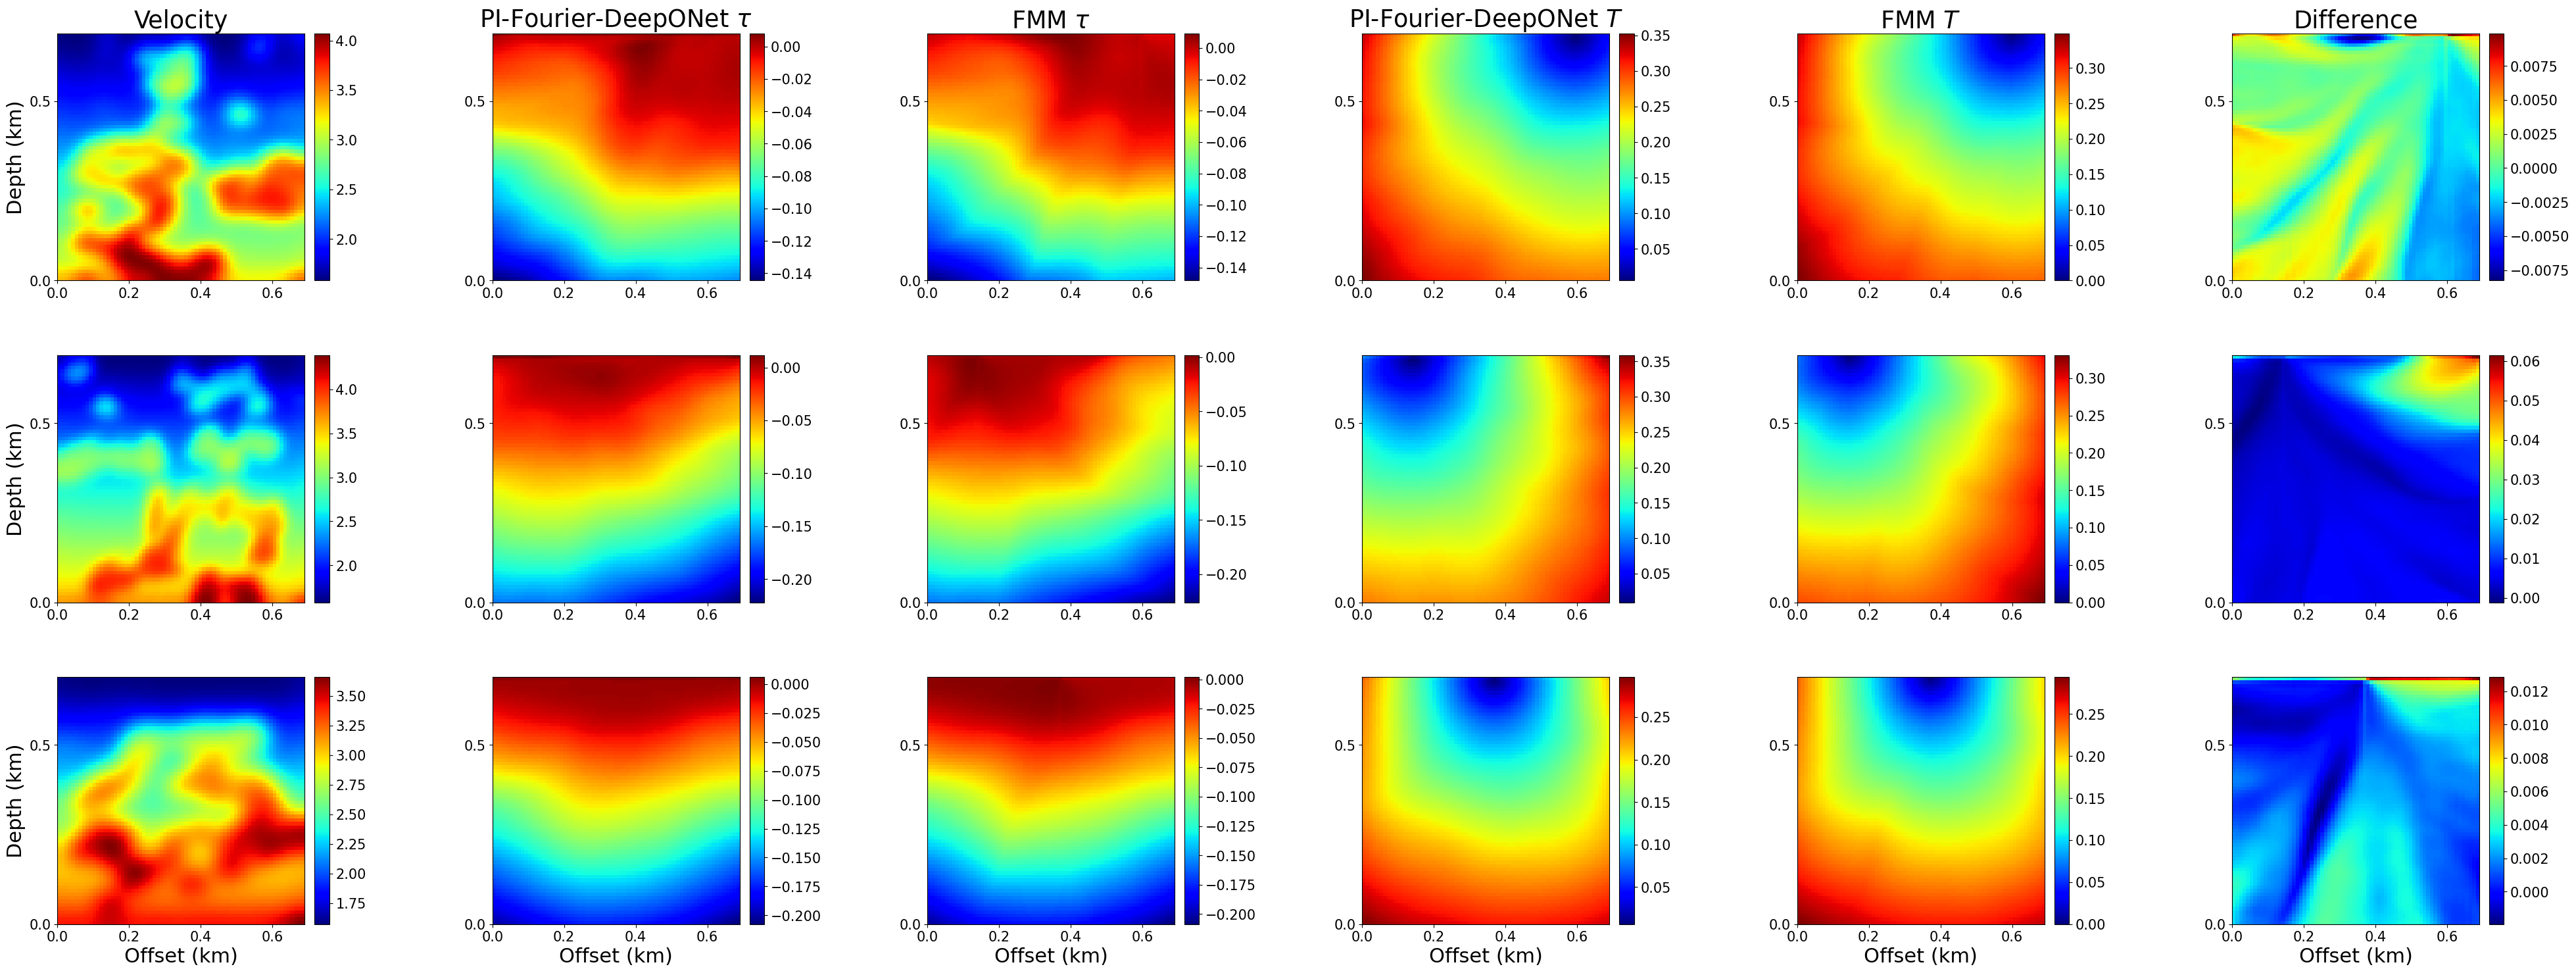

In [55]:
# Validation
opt_params = model.get_params(model.opt_state)

source_test_1 = [random_source_loc[0]]
velmodel_test1 = velocity_family[20]/1000
V_test_1, T0_test_1, coord_test_1, tau_test_1, T_test_1,sloc_test_1 ,px_test_1, pz_test_1, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test1, source = jnp.array(source_test_1))
tau_pred1 = model.predict(opt_params, T0_test_1, V_test_1)
T_pred1 = T0_test_1[0,:,:,0] + tau_pred1[0,:,:,0]

source_test_2 = [random_source_loc[1]]
velmodel_test2 = velocity_family[21]/1000
V_test_2, T0_test_2, coord_test_2 , tau_test_2, T_test_2,sloc_test_2 ,px_test_2, pz_test_2, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test2, source = jnp.array(source_test_2))
tau_pred2 = model.predict(opt_params, T0_test_2, V_test_2)
T_pred2 = T0_test_2[0,:,:,0] + tau_pred2[0,:,:,0]


source_test_3 = [random_source_loc[2]]
velmodel_test3 = velocity_family[22]/1000
V_test_3, T0_test_3, coord_test_3 , tau_test_3, T_test_3,sloc_test_3 ,px_test_3, pz_test_3, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test3, source = jnp.array(source_test_3))
tau_pred3 = model.predict(opt_params, T0_test_3, V_test_3)
T_pred3 = T0_test_3[0,:,:,0] + tau_pred3[0,:,:,0]

plt.rc('font', size=22) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# plt.rc('font', family='Arial') 

fig = plt.figure(figsize=(48,18))
ax1 = plt.subplot2grid((3,6), (0, 0))
ax2 = plt.subplot2grid((3,6), (0, 1))
ax3 = plt.subplot2grid((3,6), (0, 2))
ax4 = plt.subplot2grid((3,6), (0, 3))
ax5 = plt.subplot2grid((3,6), (0, 4))
ax6 = plt.subplot2grid((3,6), (0, 5))

pcm=ax1.imshow(velmodel_test1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax1.set_ylabel("Depth (km)")
# ax1.set_xlabel("Offset (km)")
ax1.set_title('Velocity')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax2.imshow(tau_pred1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
# ax2.set_xlabel("Offset (km)")
ax2.set_title(r'PI-Fourier-DeepONet $\tau$')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax3.imshow(tau_test_1[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
# ax3.set_xlabel("Offset (km)")
ax3.set_title(r'FMM $\tau$')
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax4.imshow(T_pred1, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
# ax4.set_xlabel("Offset (km)")
ax4.set_title(r'PI-Fourier-DeepONet $T$')
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax5.imshow(T_test_1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
# ax5.set_xlabel("Offset (km)")
ax5.set_title(r'FMM $T$')
ax5.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax6.imshow(tau_pred1[0,:,:,0]-tau_test_1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
# ax6.set_xlabel("Offset (km)")
ax6.set_title(r'Difference')
ax6.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

ax21 = plt.subplot2grid((3,6), (1, 0))
ax22 = plt.subplot2grid((3,6), (1, 1))
ax23 = plt.subplot2grid((3,6), (1, 2))
ax24 = plt.subplot2grid((3,6), (1, 3))
ax25 = plt.subplot2grid((3,6), (1, 4))
ax26 = plt.subplot2grid((3,6), (1, 5))

pcm=ax21.imshow(velmodel_test2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax21.set_ylabel("Depth (km)")
# ax21.set_xlabel("Offset (km)")
ax21.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax21)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax22.imshow(tau_pred2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
# ax22.set_xlabel("Offset (km)")
ax22.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax22)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax23.imshow(tau_test_2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
# ax23.set_xlabel("Offset (km)")
ax23.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax23)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax24.imshow(T_pred2, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
# ax24.set_xlabel("Offset (km)")
ax24.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax24)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax25.imshow(T_test_2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
# ax25.set_xlabel("Offset (km)")
ax25.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax25)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax26.imshow(tau_pred2[0,:,:,0]-tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
# ax26.set_xlabel("Offset (km)")
ax26.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax26)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)



ax31 = plt.subplot2grid((3,6), (2, 0))
ax32 = plt.subplot2grid((3,6), (2, 1))
ax33 = plt.subplot2grid((3,6), (2, 2))
ax34 = plt.subplot2grid((3,6), (2, 3))
ax35 = plt.subplot2grid((3,6), (2, 4))
ax36 = plt.subplot2grid((3,6), (2, 5))

pcm=ax31.imshow(velmodel_test3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax31.set_ylabel("Depth (km)")
ax31.set_xlabel("Offset (km)")
ax31.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax31)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax32.imshow(tau_pred3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
ax32.set_xlabel("Offset (km)")
ax32.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax32)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax33.imshow(tau_test_3[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
ax33.set_xlabel("Offset (km)")
ax33.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax33)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax34.imshow(T_pred3, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
ax34.set_xlabel("Offset (km)")
ax34.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax34)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax35.imshow(T_test_3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
ax35.set_xlabel("Offset (km)")
ax35.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax35)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax36.imshow(tau_pred3[0,:,:,0]-tau_test_3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
ax36.set_xlabel("Offset (km)")
ax36.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax36)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

fig.subplots_adjust(wspace=0.6)

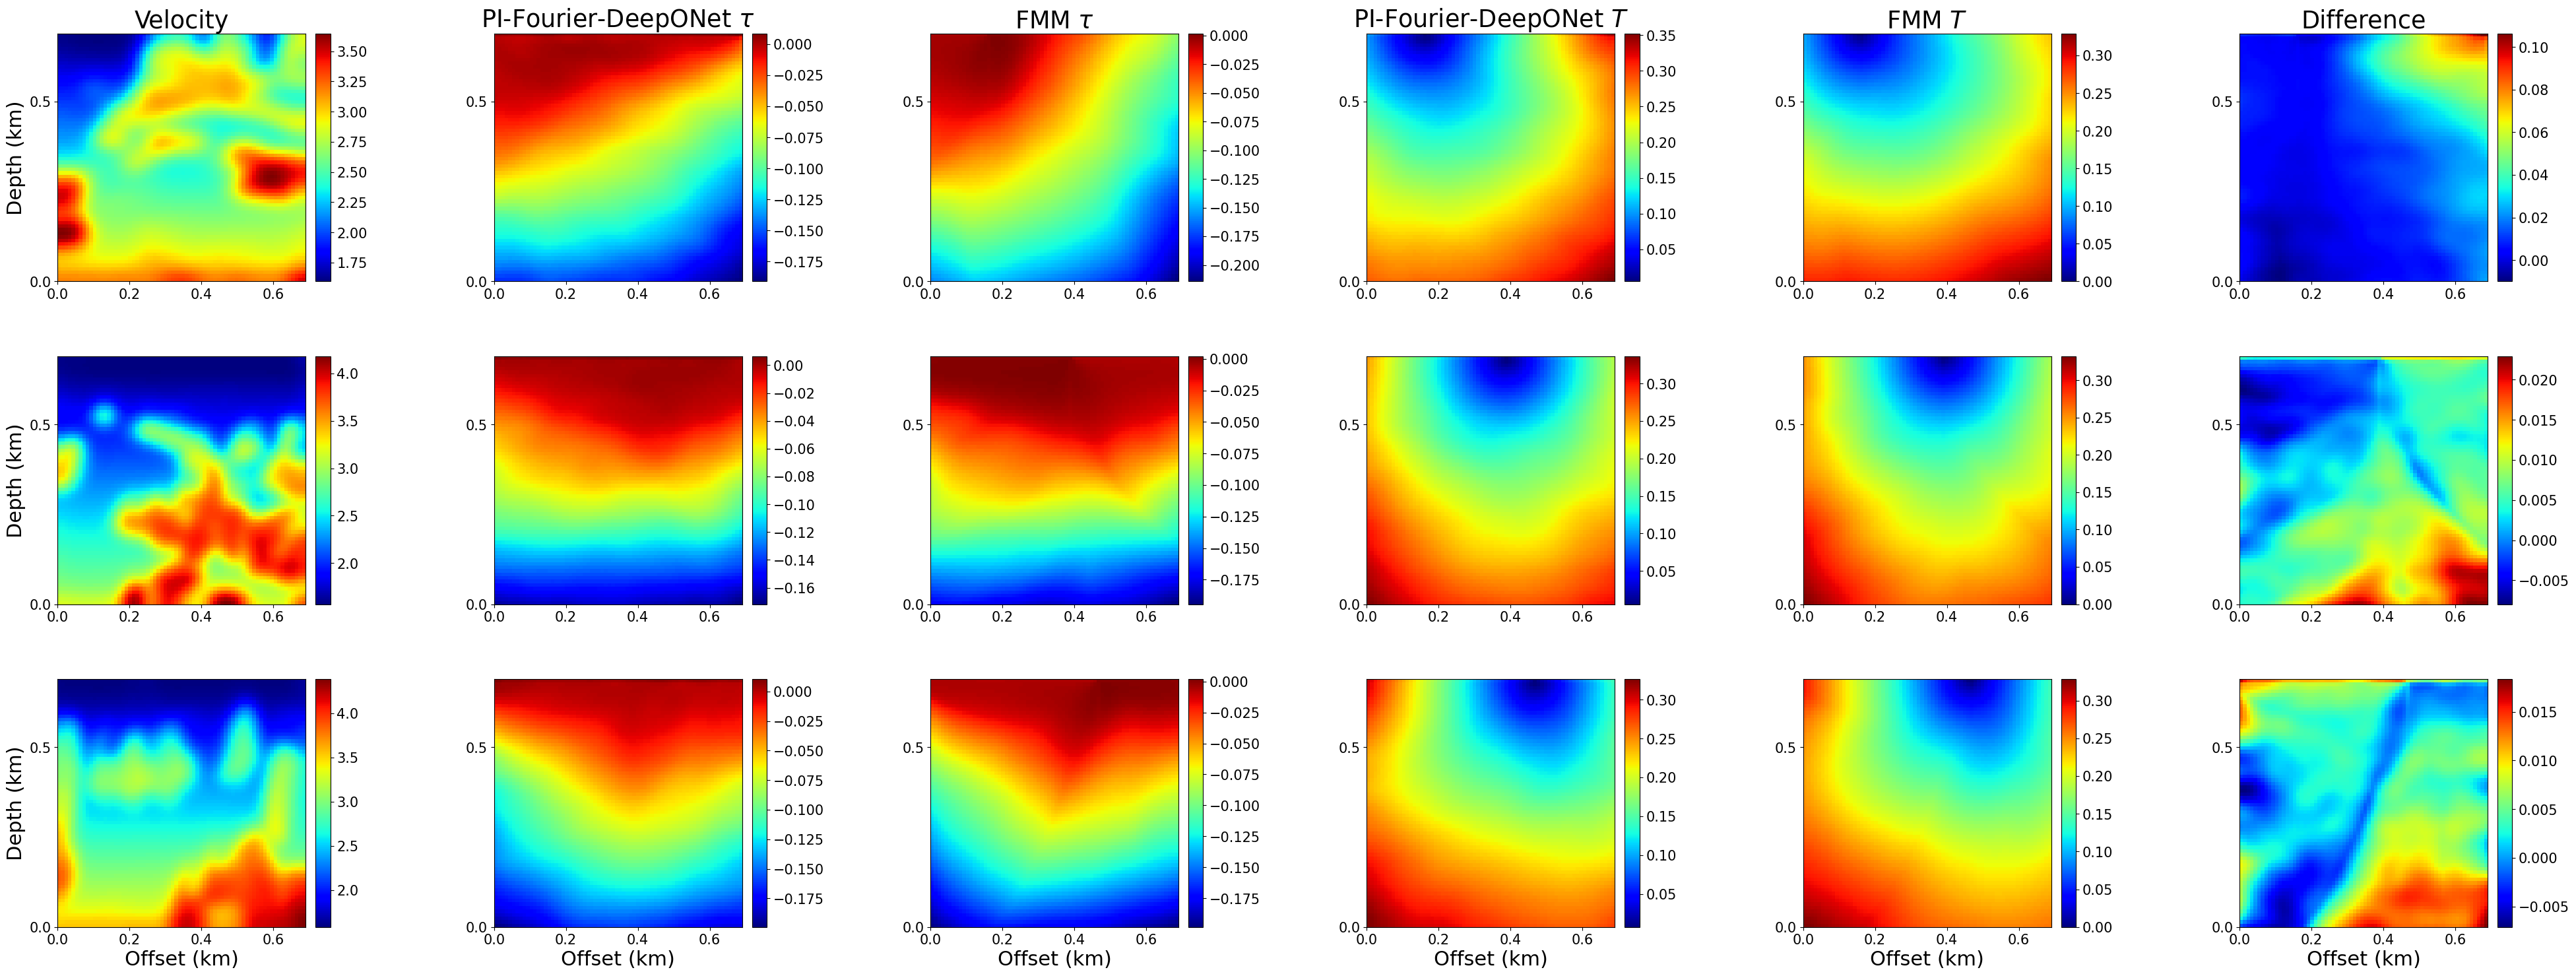

In [56]:
source_test_1 = [random_source_loc[13]]
velmodel_test1 = velocity_family[200]/1000
V_test_1, T0_test_1, coord_test_1, tau_test_1, T_test_1,sloc_test_1 ,px_test_1, pz_test_1, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test1, source = jnp.array(source_test_1))
tau_pred1 = model.predict(opt_params, T0_test_1, V_test_1)
T_pred1 = T0_test_1[0,:,:,0] + tau_pred1[0,:,:,0]

source_test_2 = [random_source_loc[14]]
velmodel_test2 = velocity_family[201]/1000
V_test_2, T0_test_2, coord_test_2 , tau_test_2, T_test_2,sloc_test_2 ,px_test_2, pz_test_2, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test2, source = jnp.array(source_test_2))
tau_pred2 = model.predict(opt_params, T0_test_2, V_test_2)
T_pred2 = T0_test_2[0,:,:,0] + tau_pred2[0,:,:,0]


source_test_3 = [random_source_loc[15]]
velmodel_test3 = velocity_family[202]/1000
V_test_3, T0_test_3, coord_test_3 , tau_test_3, T_test_3,sloc_test_3 ,px_test_3, pz_test_3, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test3, source = jnp.array(source_test_3))
tau_pred3 = model.predict(opt_params, T0_test_3, V_test_3)
T_pred3 = T0_test_3[0,:,:,0] + tau_pred3[0,:,:,0]

plt.rc('font', size=22) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# plt.rc('font', family='Arial') 

fig = plt.figure(figsize=(48,18))
# ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((3,6), (0, 0))
ax2 = plt.subplot2grid((3,6), (0, 1))
ax3 = plt.subplot2grid((3,6), (0, 2))
ax4 = plt.subplot2grid((3,6), (0, 3))
ax5 = plt.subplot2grid((3,6), (0, 4))
ax6 = plt.subplot2grid((3,6), (0, 5))

pcm=ax1.imshow(velmodel_test1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax1.set_ylabel("Depth (km)")
# ax1.set_xlabel("Offset (km)")
ax1.set_title('Velocity')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax2.imshow(tau_pred1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
# ax2.set_xlabel("Offset (km)")
ax2.set_title(r'PI-Fourier-DeepONet $\tau$')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax3.imshow(tau_test_1[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
# ax3.set_xlabel("Offset (km)")
ax3.set_title(r'FMM $\tau$')
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax4.imshow(T_pred1, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
# ax4.set_xlabel("Offset (km)")
ax4.set_title(r'PI-Fourier-DeepONet $T$')
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax5.imshow(T_test_1[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
# ax5.set_xlabel("Offset (km)")
ax5.set_title(r'FMM $T$')
ax5.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax6.imshow(tau_pred1[0,:,:,0]-tau_test_1[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
# ax6.set_xlabel("Offset (km)")
ax6.set_title(r'Difference')
ax6.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)



ax21 = plt.subplot2grid((3,6), (1, 0))
ax22 = plt.subplot2grid((3,6), (1, 1))
ax23 = plt.subplot2grid((3,6), (1, 2))
ax24 = plt.subplot2grid((3,6), (1, 3))
ax25 = plt.subplot2grid((3,6), (1, 4))
ax26 = plt.subplot2grid((3,6), (1, 5))

pcm=ax21.imshow(velmodel_test2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax21.set_ylabel("Depth (km)")
# ax21.set_xlabel("Offset (km)")
ax21.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax21)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax22.imshow(tau_pred2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
# ax22.set_xlabel("Offset (km)")
ax22.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax22)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax23.imshow(tau_test_2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
# ax23.set_xlabel("Offset (km)")
ax23.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax23)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax24.imshow(T_pred2, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
# ax24.set_xlabel("Offset (km)")
ax24.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax24)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax25.imshow(T_test_2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
# ax25.set_xlabel("Offset (km)")
ax25.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax25)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax26.imshow(tau_pred2[0,:,:,0]-tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
# ax26.set_xlabel("Offset (km)")
ax26.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax26)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)



ax31 = plt.subplot2grid((3,6), (2, 0))
ax32 = plt.subplot2grid((3,6), (2, 1))
ax33 = plt.subplot2grid((3,6), (2, 2))
ax34 = plt.subplot2grid((3,6), (2, 3))
ax35 = plt.subplot2grid((3,6), (2, 4))
ax36 = plt.subplot2grid((3,6), (2, 5))

pcm=ax31.imshow(velmodel_test3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax31.set_ylabel("Depth (km)")
ax31.set_xlabel("Offset (km)")
ax31.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax31)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax32.imshow(tau_pred3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
ax32.set_xlabel("Offset (km)")
ax32.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax32)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax33.imshow(tau_test_3[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
ax33.set_xlabel("Offset (km)")
ax33.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax33)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax34.imshow(T_pred3, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
ax34.set_xlabel("Offset (km)")
ax34.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax34)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax35.imshow(T_test_3[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
ax35.set_xlabel("Offset (km)")
ax35.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax35)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax36.imshow(tau_pred3[0,:,:,0]-tau_test_3[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
ax36.set_xlabel("Offset (km)")
ax36.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax36)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

fig.subplots_adjust(wspace=0.6)
# plt.tight_layout()

In [ ]:
class DeepONet:
    def __init__(self, input_shape, layers, layers_branch1, layers_branch2):
        # Apply and init functions
        self.init, self.apply = serial(*layers) 
        self.init_branch1, self.apply_branch1 = serial(*layers_branch1) 
        self.init_branch2, self.apply_branch2 = serial(*layers_branch2) 
        
        _, params_FNO = self.init(random.PRNGKey(10000), input_shape)
        _, params_branch1 = self.init_branch1(random.PRNGKey(10000), input_shape)
        _, params_branch2 = self.init_branch2(random.PRNGKey(10000), input_shape)
        params = (params_FNO, params_branch1, params_branch2)

        # Relative L2 loss
        self.L2Loss = LpLoss()

        # Optimizer
        self.opt_init, self.opt_update, self.get_params = complex_adam(1e-4)

        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        self.loss_log = []

    def operator(self, params, T0, V):
        params_FNO, params_branch1, params_branch2 = params
        
        B1 = self.apply_branch1(params_branch1, T0)
        B2 = self.apply_branch2(params_branch2, V)

        outputs = B1*B2
        
        return outputs

    @partial(jit, static_argnums=0)
    def loss(self, params, batch):
        T0, V, pz, px, targets = batch
        
        outputs = self.operator(params, T0, V)
        loss = self.L2Loss(outputs, targets)
        return loss   
    @partial(jit, static_argnums=0)
    def loss_PINN(self, params, batch):
        T0, V, pz, px, targets, source = batch
        # mask = mask.at[:,0,:].set(0)
        
        T0 = T0.reshape(-1,m,1)
        V = V.reshape(-1,m,1)
        
        tau = self.operator(params, T0, V)
        tau = tau.reshape(-1, grid_size, grid_size,1)
        
        # tau = tau*mask
        tau = tau.at[:,0,:].set(0)
        
        dtau_dz = jnp.gradient(tau.reshape(-1, grid_size, grid_size), z_delta, axis=1)
        dtau_dx = jnp.gradient(tau.reshape(-1, grid_size, grid_size), x_delta, axis=2)
        
        term1 = dtau_dz + pz
        term2 = dtau_dx + px
        
        V = V.reshape(-1, grid_size, grid_size)
        
        pde = term1**2 +term2**2 - 1/ V**2
        
        loss = self.MSE(pde,jnp.zeros(pde.shape)) 
        return loss 

    
    def MSE(self, true,pred):
        return jnp.mean((true.flatten()-pred.flatten())**2)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, f_weights, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_PINN)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, dataset, f_weights, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, f_weights, batch)
            # Logger
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_PINN(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])
    def predict(self, params, T0, V):
        T0 = T0.reshape(-1,m,1)
        V = V.reshape(-1,m,1)
        params_FNO, params_branch1, params_branch2 = params
        # inputs, targets = batch
        outputs = self.operator(params, T0, V)
        outputs = outputs.reshape(-1, grid_size, grid_size)
        return outputs


layers_branch1 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(1)
                  ]
layers_branch2 = [Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(width),
                  Gelu,
                  Dense(1)
                  ]

model_DeepONet = DeepONet(input_shape, layers, layers_branch1, layers_branch2)
model_DeepONet.count_params()

# Training
start_time = timeit.default_timer()
model_DeepONet.train(train_dataset, f_weights, nIter=nIter)

elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

loss = jnp.array(model.loss_log)

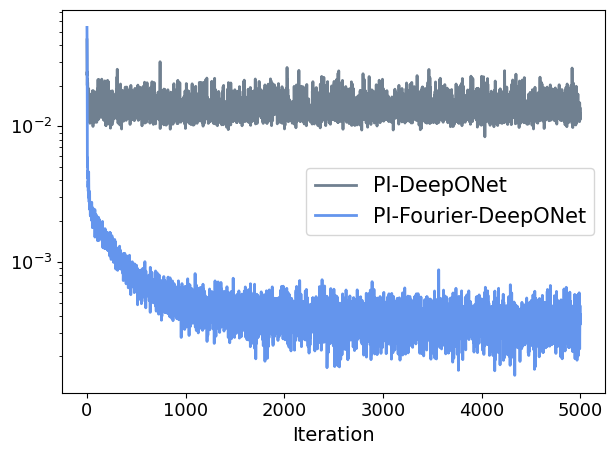

In [60]:
plt.figure()
plt.plot(model_DeepONet.loss_log, lw=2,label='PI-DeepONet',color='slategray')
plt.plot(model.loss_log, lw=2,label='PI-Fourier-DeepONet',color='cornflowerblue')
plt.xlabel('Iteration', fontsize=14)
plt.yscale('log')
plt.legend()        
plt.tight_layout()
plt.show()

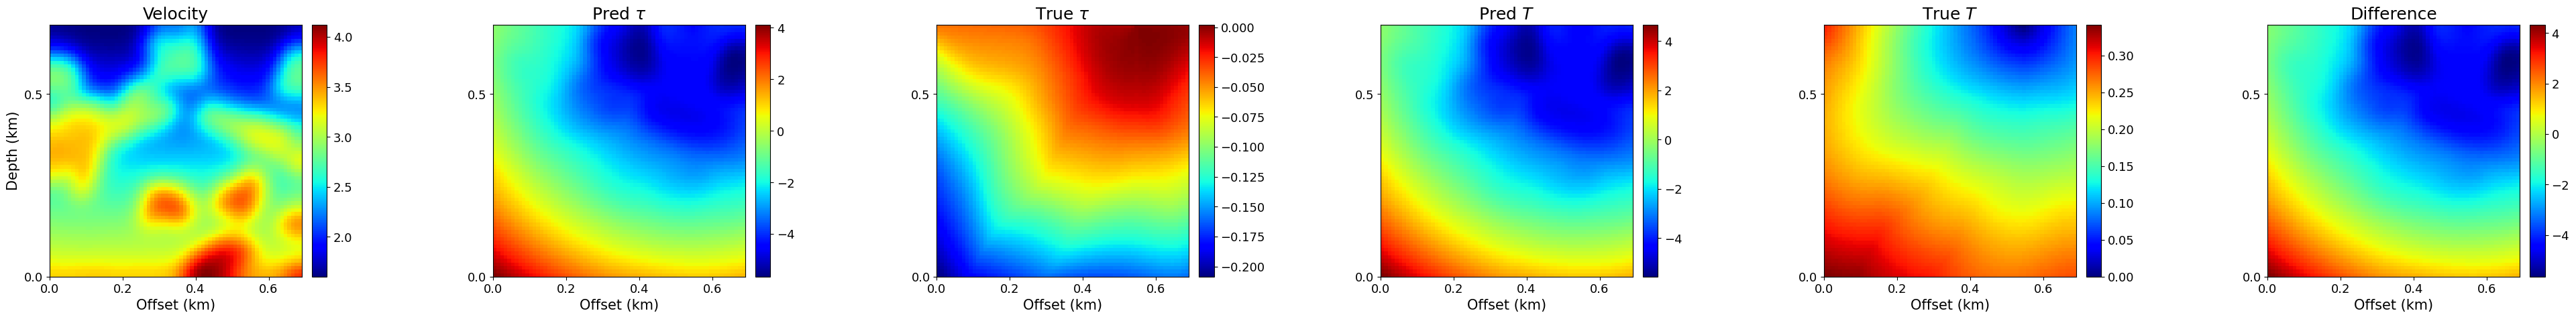

In [58]:
# Validation
opt_params = model_DeepONet.get_params(model.opt_state)

source_test_2 = [random_source_loc[9]]
velmodel_test = velocity_family[11]/1000
V_test_2, T0_test_2, coord_test_2 , tau_test_2, T_test_2,sloc_test_2 ,px_test_2, pz_test_2, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test, source = jnp.array(source_test_2))

T0_test2 = jnp.tile(T0_test_2, (1,1,1,1))
V_test2 = jnp.tile(V_test_2, (1,1,1,1))

tau_pred2 = model_DeepONet.predict(opt_params, T0_test2, V_test2)
T_pred2 = T0_test_2[0,:,:,0] + tau_pred2[0,:,:]

plt.rc('font', size=15) 
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 
# plt.rc('font', family='Arial') 

fig = plt.figure(figsize=(48,8))
# ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((1,6), (0, 0))
ax2 = plt.subplot2grid((1,6), (0, 1))
ax3 = plt.subplot2grid((1,6), (0, 2))
ax4 = plt.subplot2grid((1,6), (0, 3))
ax5 = plt.subplot2grid((1,6), (0, 4))
ax6 = plt.subplot2grid((1,6), (0, 5))

pcm=ax1.imshow(velmodel_test[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax1.set_ylabel("Depth (km)")
ax1.set_xlabel("Offset (km)")
ax1.set_title('Velocity')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax2.imshow(tau_pred2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
ax2.set_xlabel("Offset (km)")
ax2.set_title(r'Pred $\tau$')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax3.imshow(tau_test_2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
ax3.set_xlabel("Offset (km)")
ax3.set_title(r'True $\tau$')
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax4.imshow(T_pred2, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
ax4.set_xlabel("Offset (km)")
ax4.set_title(r'Pred $T$')
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax5.imshow(T_test_2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
ax5.set_xlabel("Offset (km)")
ax5.set_title(r'True $T$')
ax5.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax6.imshow(tau_pred2[0,:,:]-tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)",fontsize=25)
ax6.set_xlabel("Offset (km)")
ax6.set_title(r'Difference')
ax6.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

fig.subplots_adjust(wspace=0.6)

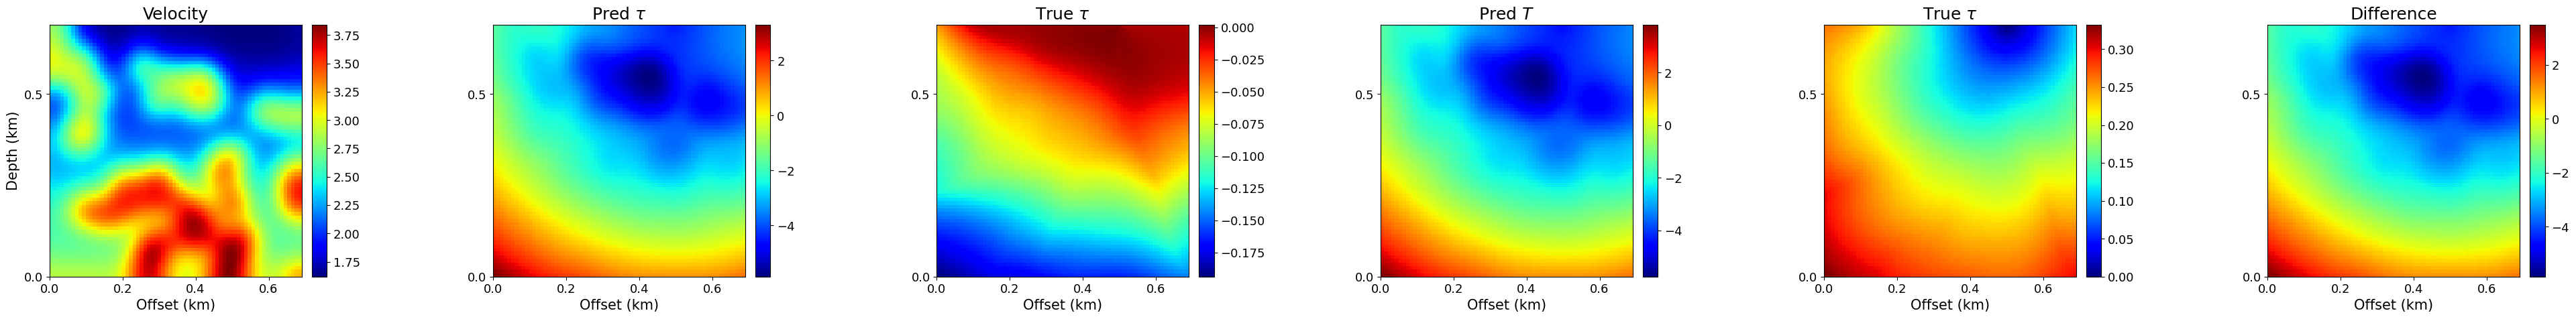

In [59]:
source_test_2=[(0,50)]
velmodel_test = velocity_family[410]/1000
V_test_2, T0_test_2, coord_test_2 , tau_test_2, T_test_2,sloc_test_2 ,px_test_2, pz_test_2, _= gen_data(num_sources=1,num_velocity=1,
                                                    velocity_model= velmodel_test, source = jnp.array(source_test_2))

T0_test2 = jnp.tile(T0_test_2, (1,1,1,1))
V_test2 = jnp.tile(V_test_2, (1,1,1,1))

tau_pred2 = model_DeepONet.predict(opt_params, T0_test2, V_test2)
T_pred2 = T0_test_2[0,:,:,0] + tau_pred2[0,:,:]

fig = plt.figure(figsize=(48,8))
# ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((1,6), (0, 0))
ax2 = plt.subplot2grid((1,6), (0, 1))
ax3 = plt.subplot2grid((1,6), (0, 2))
ax4 = plt.subplot2grid((1,6), (0, 3))
ax5 = plt.subplot2grid((1,6), (0, 4))
ax6 = plt.subplot2grid((1,6), (0, 5))

pcm=ax1.imshow(velmodel_test[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
ax1.set_ylabel("Depth (km)")
ax1.set_xlabel("Offset (km)")
ax1.set_title('Velocity')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax2.imshow(tau_pred2[0,:,:], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax2.set_ylabel("Depth (km)")
ax2.set_xlabel("Offset (km)")
ax2.set_title(r'Pred $\tau$')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax3.imshow(tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax3.set_ylabel("Depth (km)")
ax3.set_xlabel("Offset (km)")
ax3.set_title(r'True $\tau$')
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax4.imshow(T_pred2, cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax4.set_ylabel("Depth (km)")
ax4.set_xlabel("Offset (km)")
ax4.set_title(r'Pred $T$')
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax5.imshow(T_test_2[0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax5.set_ylabel("Depth (km)")
ax5.set_xlabel("Offset (km)")
ax5.set_title(r'True $\tau$')
ax5.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

pcm=ax6.imshow(tau_pred2[0,:,:]-tau_test_2[0,:,:,0], cmap="jet", 
                extent=[0,(grid_size-1)*z_delta ,0, (grid_size-1)*z_delta ])
# ax6.set_ylabel("Depth (km)")
ax6.set_xlabel("Offset (km)")
ax6.set_title(r'Difference')
ax6.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='6%', pad=0.15)
cbar = plt.colorbar(pcm, cax=cax)

fig.subplots_adjust(wspace=0.6)